## Embedding preparing

Load embedding from SpikeGPT

In [1]:
# Clone needed data and repositories
!git clone https://huggingface.co/ridger/SpikeGPT-OpenWebText-216M
!git clone https://github.com/ridgerchu/SpikeGPT.git
!pip install torch matplotlib numpy tqdm torchvision scipy ninja accelerate transformers torch_geometric


Cloning into 'SpikeGPT-OpenWebText-216M'...
remote: Enumerating objects: 13, done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 13
Unpacking objects: 100% (13/13), 1.51 KiB | 257.00 KiB/s, done.
Cloning into 'SpikeGPT'...
remote: Enumerating objects: 267, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 267 (delta 47), reused 15 (delta 7), pack-reused 187
Receiving objects: 100% (267/267), 1.28 MiB | 5.10 MiB/s, done.
Resolving deltas: 100% (104/104), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.9 MB/s eta 0:00:00


In [2]:
import matplotlib.ticker as ticker
import numpy as np
import math, os, sys, types, time, gc
import torch
from torch import nn

def prepare_env():
    try:
        os.environ["CUDA_VISIBLE_DEVICES"] = sys.argv[1]
    except:
        pass
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cuda.matmul.allow_tf32 = True
    np.set_printoptions(precision=4, suppress=True, linewidth=200)
    args = types.SimpleNamespace()

    args.RUN_DEVICE = "cpu" # 'cuda' // 'cpu' (already fast)
    args.FLOAT_MODE = "fp32" # fp16 (good for GPU, does not work for CPU) // fp32 (good for CPU) // bf16 (less accurate, but works for CPU)
    os.environ["RWKV_JIT_ON"] = '1' # '1' or '0'. very useful for GPU/CPU fp32, but might be harmful for GPU fp16. please benchmark !!!
    vocab_size = 50277

    # MODEL_NAME = model_path + 'SpikeGPT-216M'
    n_layer = 18
    n_embd = 768
    ctx_len = 1024

    # args.MODEL_NAME = MODEL_NAME
    args.n_layer = n_layer
    args.n_embd = n_embd
    args.ctx_len = ctx_len
    args.vocab_size = vocab_size
    args.head_qk = 0
    args.pre_ffn = 0
    args.grad_cp = 0
    args.my_pos_emb = 0
    os.environ["RWKV_RUN_DEVICE"] = args.RUN_DEVICE
    return args

In [3]:
%cd SpikeGPT
args = prepare_env()

from src.utils import TOKENIZER
from src.model_run import RWKV_RNN

def load_embedding_weights(model_path, args):
    # Return nn.Embedding with weights from SpikeGPT embedding
    MODEL_NAME = model_path + 'SpikeGPT-216M'
    args.MODEL_NAME = MODEL_NAME

    # Load pretrained state
    model = RWKV_RNN(args)

    # Get embedding layer from the model
    emb = nn.Embedding(num_embeddings=args.vocab_size, embedding_dim=args.n_embd)
    emb.weight.data = model.w.emb.weight.data

    return emb

def load_tokenizer():
    TOKEN_MODE = "pile"
    WORD_NAME = [
        "20B_tokenizer.json",
        "20B_tokenizer.json",
    ]  # [vocab, vocab] for Pile model
    UNKNOWN_CHAR = None

    tokenizer = TOKENIZER(WORD_NAME, UNKNOWN_CHAR=UNKNOWN_CHAR)
    if TOKEN_MODE == "pile":
        assert tokenizer.tokenizer.decode([187]) == '\n'
    return tokenizer


def transform_text_pretrained_embedding(text, emb, tokenizer):
    if tokenizer.charMode:
        context = tokenizer.refine_context(text)
        ctx = [tokenizer.stoi.get(s, tokenizer.UNKNOWN_CHAR) for s in text]
    else:
        ctx = tokenizer.tokenizer.encode(text)
    # print("Number of tokens:", len(ctx))

    return emb(torch.tensor(ctx))


emb = load_embedding_weights("/content/SpikeGPT-OpenWebText-216M/", args)
tokenizer = load_tokenizer()
%cd ..

/content/SpikeGPT

RWKV_HEAD_QK_DIM 0 RWKV_JIT_ON 1

emb.weight                               float32    cpu
blocks.0.ln1.weight                      float32    cpu
blocks.0.ln1.bias                        float32    cpu
blocks.0.ln2.weight                      float32    cpu
blocks.0.ln2.bias                        float32    cpu
blocks.0.ln0.weight                      float32    cpu
blocks.0.ln0.bias                        float32    cpu
blocks.0.att.time_decay                  float32    cpu
blocks.0.att.time_first                  float32    cpu
blocks.0.att.time_mix_k                  float32    cpu
blocks.0.att.time_mix_v                  float32    cpu
blocks.0.att.time_mix_r                  float32    cpu
blocks.0.att.key.weight                  float32    cpu
blocks.0.att.value.weight                float32    cpu
blocks.0.att.receptance.weight           float32    cpu
blocks.0.att.output.weight               float32    cpu
blocks.0.ffn.time_mix_k                  float32   

In [4]:
text = "In a shocking finding, scientist discovered a herd of dragons living in a remote, previously unexplored valley, in Tibet."
len(tokenizer.tokenizer.encode(text))

24

In [5]:
text = "In a shocking finding, scientist discovered a herd of dragons living in a remote, previously unexplored valley, in Tibet."
result = transform_text_pretrained_embedding(text, emb, tokenizer)
result.shape

torch.Size([24, 768])

# Graph creation

In [7]:
!pip install gdown
!pip install torch_geometric

In [8]:
import gdown

url = "https://drive.google.com/drive/folders/1Jx3Cz7t0hiNdtlBWUdPjhtLwPOH3LtzC"
output = './'

gdown.download_folder(url, output = output, quiet = True)

['./webnlg/test.json',
 './webnlg/test.source',
 './webnlg/test.target',
 './webnlg/train.json',
 './webnlg/val.json']

In [9]:
import json
file_dir = "./webnlg/"

with open (file_dir + "train.json", "r") as f:
    train_set = json.load(f)


with open (file_dir + "val.json", "r") as f:
    val_set = json.load(f)


with open (file_dir + "test.json", "r") as f:
    test_set = json.load(f)

test_set[2]['kbs']

{'W1016': ['California',
  'California',
  [['is part of', 'Anaheim, California']]],
 'W1277': ['United States',
  'United States',
  [['location', 'United States House of Representatives']]],
 'W3706': ['United States House of Representatives',
  'United States House of Representatives',
  [['leader title', 'Anaheim, California']]]}

In [10]:
def get_triplets(dataset_element):
    triplets = []
    for key, value in dataset_element['kbs'].items():
        triplets.append([value[0]]+value[-1][0])
    return triplets

get_triplets(test_set[2])

[['California', 'is part of', 'Anaheim, California'],
 ['United States', 'location', 'United States House of Representatives'],
 ['United States House of Representatives',
  'leader title',
  'Anaheim, California']]

Albany , Georgia is in the United States , a country led by the President of the United States and where the inhabitants are called Americans . One of the ethnic groups in the country are the African Americans

In [11]:
import numpy as np
import torch
from torch_geometric.data import Data

def get_tokens(nodes_list, averaging=False):
    global emb, tokenizer
    result = []
    for el in nodes_list:
        embeddings = transform_text_pretrained_embedding(el, emb, tokenizer)
        result.append(embeddings.detach().tolist())
    return result

def replace_embedding(nodes_tokens):
    global emb
    res = []
    for n in nodes_tokens:
        res.append([])
        for i in n:
            print(i)
            res[-1].append(emb(i))
    return res

def create_graph(triplets, text, with_text=True):
    x = []
    edge_index = []
    y = text

    for t in triplets:

        # Create nodes as unique words
        if t[0] not in x:
            x.append(t[0])
        if t[2] not in x:
            x.append(t[2])

        # Add edge
        edge_index.append([x.index(t[0]), x.index(t[2])])

    x = get_tokens(x, averaging=True)
    k = 3
    # print(len(x))
    for i in range(len(x)):
        if len(x[i]) < k:
            x[i] += emb(torch.tensor( [1] * (k - len(x[i])))).detach().tolist()
        else:
            x[i] = x[i][:k]
        x[i] = sum(x[i], [])
    x = torch.tensor(x)

    edge_index = np.array(edge_index).T
    edge_index = torch.tensor(edge_index, dtype=torch.long)

    # Do not store initial text for train sets
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    return data

data = create_graph(get_triplets(test_set[0]), test_set[0]['text'][0], with_text=True)

In [13]:
get_triplets(test_set[0])

[['Pakistan', 'location', 'Allama Iqbal International Airport'],
 ['2900.0', 'runway length', 'Allama Iqbal International Airport'],
 ['Pakistan Civil Aviation Authority',
  'operating organisation',
  'Allama Iqbal International Airport'],
 ['Lahore', 'city served', 'Allama Iqbal International Airport']]

In [14]:
import torch
from torch_geometric.data import InMemoryDataset, download_url
import json

class GraphDataset(InMemoryDataset):
    def __init__(self, root, file_path, transform=None, pre_transform=None, pre_filter=None):
        self.file_path = file_path
        super().__init__(root, transform, pre_transform, pre_filter)
        self.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [self.file_path]

    @property
    def processed_file_names(self):
        return [".".join(self.file_path.split(".")[:-1])+".pt"]

    def download(self):
        # Download to `self.raw_dir`.
        if ".pt" not in self.raw_file_names[0]:
            with open (self.raw_file_names[0], "r") as f:
                return json.load(f)
        else:
            return torch.load("processed/"+self.raw_file_names[0])

    def process(self):
        # Read data into huge `Data` list.
        data_list = []

        if ".pt" in self.raw_file_names[0]:
            return
        data  = self.download()
        for datapoint in data:
            data_list.append(create_graph(get_triplets(datapoint), datapoint['text'][0]))
        # print("processing")
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])

In [ ]:
%mkdir processed
%mkdir processed/webnlg

val_dataset = GraphDataset("./", "webnlg/val.json")
train_dataset = GraphDataset("./", "webnlg/train.json")
test_dataset = GraphDataset("./", "webnlg/test.json")

In [16]:
import gc
gc.collect()

9

In [17]:
val_dataset[0].x.shape

torch.Size([4, 2304])

## Graph visualization

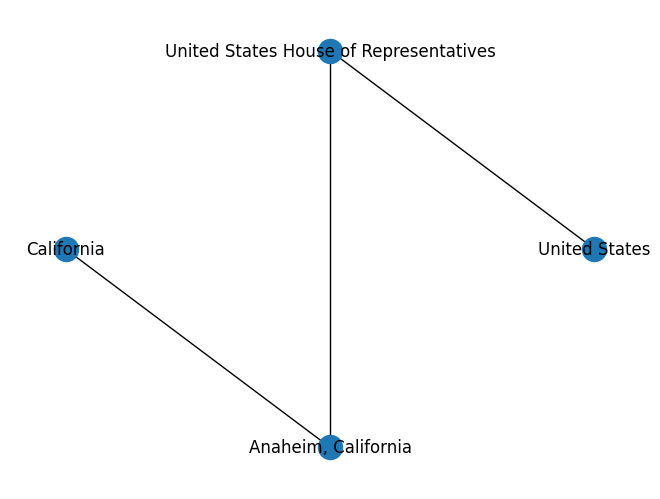

In [ ]:
import numpy as np
import torch
from torch_geometric.data import Data
import torch_geometric
import networkx as nx

def get_tokens(nodes_list, averaging=False):
    global emb, tokenizer
    result = []
    for el in nodes_list:
        embeddings = transform_text_pretrained_embedding(el, emb, tokenizer)
        result.append(embeddings.detach().tolist())
    return result

def replace_embedding(nodes_tokens):
    global emb
    res = []
    for n in nodes_tokens:
        res.append([])
        for i in n:
            print(i)
            res[-1].append(emb(i))
    return res

def create_graph_in_text(triplets, text):
    x = []
    edge_index = []
    edge_attr = []
    y = text

    for t in triplets:

        # Create nodes as unique words
        if t[0] not in x:
            x.append(t[0])
        if t[2] not in x:
            x.append(t[2])

        # Add edge
        ind1, ind2 = x.index(t[0]), x.index(t[2])
        edge_index.append([min(ind1, ind2), max(ind1, ind2)])

        # Add edge attribute
        edge_attr.append(t[1])

    edge_index = np.array(edge_index).T
    edge_index = torch.tensor(edge_index, dtype=torch.long)

    # Do not store initial text for train sets
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=text)
    return data

def draw_graph(graph):
    data = create_graph_in_text(get_triplets(graph),graph['text'][0])
    g = torch_geometric.utils.to_networkx(data, to_undirected=True)
    nx.draw_shell(g, labels={i:p for i, p in enumerate(data.x)})

draw_graph(test_set[2])